In [194]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [325]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.data = data
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
            
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int,float)), 'only suppoprting int/float'
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
    
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [326]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)
    
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Neuron grad example

In [163]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias 
b = Value(6.88137358, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'


In [159]:
#0 gradients
draw_dot(o)

### calculate grads manually

In [157]:
# manual grads
o.grad = 1.0
n.grad = 1-o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad =  w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
draw_dot(o)

### calculate backward manually

In [156]:
# manual backward
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

### calculate grad automatically

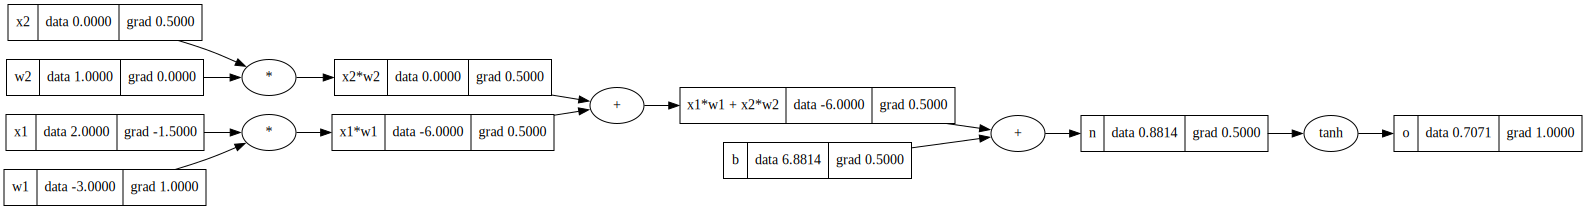

In [164]:
# auto backward
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited: 
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#     node._backward()
o.backward()    
draw_dot(o)

# same but with pytorch

In [192]:
import torch 
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True  
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## building MLP

In [339]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [419]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.39155366367255107)

In [342]:
#n.parameters()

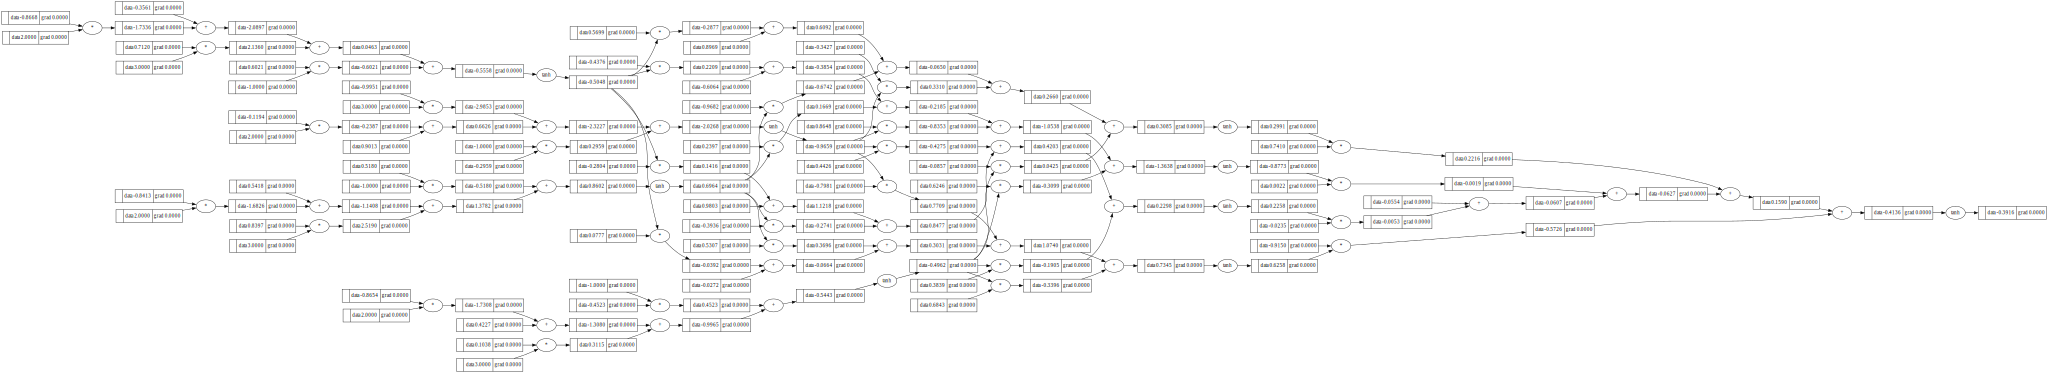

In [420]:
draw_dot(n(x))

In [421]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [444]:
lr = 0.01
nsteps = 500


for k in range(nsteps):
    # forward pass
    ypred = [n(x) for x in xs]
    
    # calculate loss
    loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
    #draw_dot(loss)

    # zero grad
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()
    
    #update weights & biases
    for p in n.parameters():
        p.data += -lr*p.grad
        
    print(f'step:{k}, loss:{loss.data}')


step:0, loss:0.007723969101031705
step:1, loss:0.007710422767034146
step:2, loss:0.0076969203922489
step:3, loss:0.0076834617696761014
step:4, loss:0.007670046693590437
step:5, loss:0.00765667495953146
step:6, loss:0.007643346364293909
step:7, loss:0.007630060705918408
step:8, loss:0.007616817783681763
step:9, loss:0.007603617398087899
step:10, loss:0.007590459350858466
step:11, loss:0.00757734344492363
step:12, loss:0.007564269484413134
step:13, loss:0.007551237274647182
step:14, loss:0.007538246622127544
step:15, loss:0.007525297334528701
step:16, loss:0.007512389220689126
step:17, loss:0.007499522090602516
step:18, loss:0.007486695755409237
step:19, loss:0.007473910027387801
step:20, loss:0.007461164719946359
step:21, loss:0.007448459647614309
step:22, loss:0.007435794626034095
step:23, loss:0.0074231694719527706
step:24, loss:0.0074105840032141004
step:25, loss:0.007398038038750209
step:26, loss:0.007385531398573671
step:27, loss:0.007373063903769572
step:28, loss:0.007360635376487

In [445]:
print(*[v.data for v in ypred])
print(ys)

0.9802845199508996 -0.9448294675367094 -0.972271699921911 0.9460835154489355
[1.0, -1.0, -1.0, 1.0]
